# 画像メディア工学１２回目

## 12. カメラ行列（透視投影行列）を用いたカメラへの投影の計算

カメラ行列を用いることで，世界座標系における３次元座標から，カメラに撮影される２次元座標が計算できる．

まず，準備として，いくつかの関数を定義する．

### ライブラリの読み込み

In [1]:
%matplotlib inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.patches as pat

import cv2

### 回転行列を計算する関数の定義
x,y,z軸の順番での回転，単位degree

引数 1つ目：x軸回転，2つ目：y軸回転，3つ目：z軸回転

In [2]:
def rotMat(a, b, c):
  a, b, c = a/180*np.pi, b/180*np.pi, c/180*np.pi
  
  # X軸まわり回転
  rotX = np.matrix([[        1.,         0.,         0.],
                    [        0.,  np.cos(a), -np.sin(a)],
                    [        0.,  np.sin(a),  np.cos(a)]])
  # Y軸まわり回転
  rotY = np.matrix([[ np.cos(b),         0.,  np.sin(b)],
                    [        0.,         1.,         0.],
                    [-np.sin(b),         0.,  np.cos(b)]])
  # Z軸まわり回転
  rotZ = np.matrix([[ np.cos(c), -np.sin(c),         0.],
                    [ np.sin(c),  np.cos(c),         0.],
                    [        0.,         0 ,         1.]])

  return rotZ*rotY*rotX

### 描画用関数の定義

In [3]:
# 座標系描画用関数
def drawCoordinate(ax, rot = np.eye(3), pos = np.zeros(3), scale = 1):
  # 座標系描画用の単位ベクトル
  xvec = np.matrix([[1.0],
                    [0.0],
                    [0.0]]) * scale
  yvec = np.matrix([[0.0],
                    [1.0],
                    [0.0]]) * scale
  zvec = np.matrix([[0.0],
                    [0.0],
                    [1.0]]) * scale

  # 単位ベクトルを回転
  xvec = rot*xvec
  yvec = rot*yvec
  zvec = rot*zvec

  # 座標系の描画
  ax.quiver(pos[0], pos[1], pos[2], xvec[0,0], xvec[1,0], xvec[2,0], linewidths=2, color='red')
  ax.quiver(pos[0], pos[1], pos[2], yvec[0,0], yvec[1,0], yvec[2,0], linewidths=2, color='green')
  ax.quiver(pos[0], pos[1], pos[2], zvec[0,0], zvec[1,0], zvec[2,0], linewidths=2, color='blue')

### 座標系の回転の比較
回転行列の作成のところの
``rotMat()``の引数を変えると，様々な回転行列が生成される．

XYZ軸がそれぞれ赤緑青で表示されており，右には回転した座標系を表示．

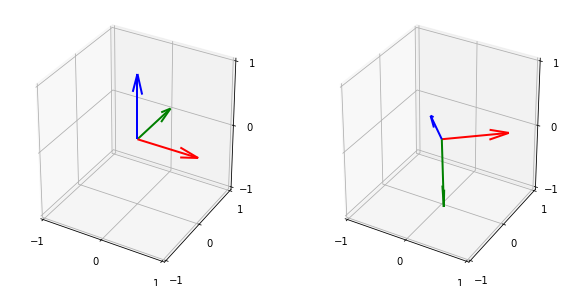

In [4]:
# プロットの設定
fig = plt.figure(figsize=(10,5))

# 左側領域の設定
ax = fig.add_subplot(121, projection='3d')
ax.set_xlim((-1.0, 1.0))
ax.set_ylim((-1.0, 1.0))
ax.set_zlim((-1.0, 1.0))
ax.set_xticks((-1, 0, 1))
ax.set_yticks((-1, 0, 1))
ax.set_zticks((-1, 0, 1))

# 座標系を描画
drawCoordinate(ax)

# 右側領域の設定
ax = fig.add_subplot(122, projection='3d')
ax.set_xlim((-1.0, 1.0))
ax.set_ylim((-1.0, 1.0))
ax.set_zlim((-1.0, 1.0))
ax.set_xticks((-1, 0, 1))
ax.set_yticks((-1, 0, 1))
ax.set_zticks((-1, 0, 1))

# 回転行列の作成（x,y,z軸の順番での回転，degree）
R = rotMat(-100, 0, 40)

# 回転した座標系を描画
drawCoordinate(ax, R)

# グラフの表示
plt.show()

### Step1 撮影対象の立方体の定義


In [5]:
# 立方体の定義
cube = np.array([[ 0,  0,  0],
                 [ 0, 10,  0],
                 [10, 10,  0],
                 [10,  0,  0],
                 [ 0,  0, 10],
                 [ 0, 10, 10],
                 [10, 10, 10],
                 [10,  0, 10]])

# 立方体の位置（課題における変更点その１）
cube_pos = np.array([[ 0, 20,  0]])

# 立方体の頂点位置
pts = cube_pos + cube

# 立方体の面の設定
verts1 = [[pts[4],pts[5],pts[6],pts[7]]] # 上面
verts2 = [[pts[0],pts[1],pts[2],pts[3]]] # 下面
verts3 = [[pts[0],pts[1],pts[5],pts[4]], # 側面
          [pts[2],pts[3],pts[7],pts[6]],
          [pts[1],pts[2],pts[6],pts[5]],
          [pts[4],pts[7],pts[3],pts[0]]]

### Step2 カメラ行列Pの作成
内部パラメータ行列AとR,Tを用いて，カメラ行列Pを作成する

In [6]:
# 世界座標系からカメラ座標系への回転行列の作成（x,y,z軸の順番での回転，degree）
Rwc = rotMat(-100, 0, 40)  # 課題における変更点その２

# 世界座標系でのカメラ位置
Tw = np.matrix([[ 25],     # 課題における変更点その３
                [  0],
                [ 15]])

# カメラ行列のためのRとTの計算
# Rは世界座標系からカメラ座標系への回転行列の逆行列
# Tはカメラ座標系における原点位置
R = np.linalg.inv(Rwc)
T = -R*Tw

# 内部パラメータ
f = 200                    # 課題における変更点その４
cx = cy = 100              # 課題における変更点その５
A = np.matrix([[f, 0, cx],
               [0, f, cy],
               [0, 0,  1]])

RT = np.matrix([[R[0,0],R[0,1],R[0,2],T[0,0]],
                [R[1,0],R[1,1],R[1,2],T[1,0]],
                [R[2,0],R[2,1],R[2,2],T[2,0]]])
#RT = np.concatenate([R, T], axis=1)

P = A * RT

### 撮影対象と座標系の描画（状況の確認）

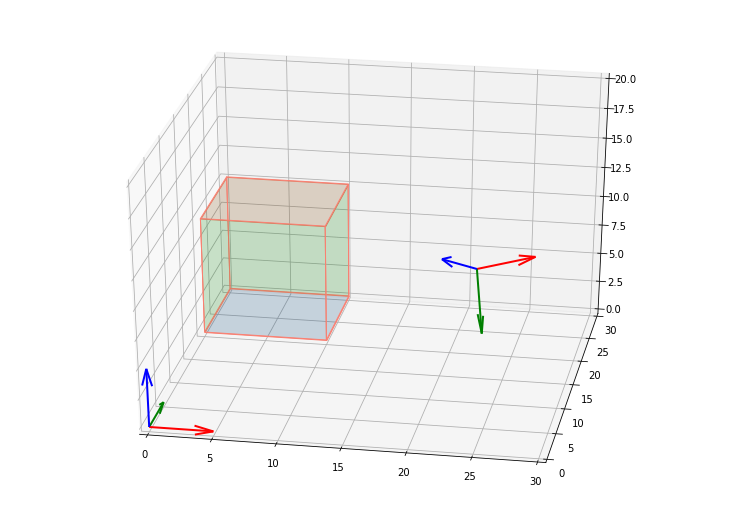

In [7]:
# プロットの設定
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)

# 描画範囲の設定
ax.set_xlim((0, 30))
ax.set_ylim((0, 30))
ax.set_zlim((0, 20))

# 座標系を描画
drawCoordinate(ax, scale=5.0)                    # 世界座標系
drawCoordinate(ax, pos=Tw, rot=Rwc, scale=5.0)   # カメラ座標系

# 立方体の描画
ax.add_collection3d(art3d.Poly3DCollection(verts1, facecolors='red', edgecolors='salmon', alpha= 0.1))
ax.add_collection3d(art3d.Poly3DCollection(verts2, facecolors='blue', edgecolors='salmon', alpha= 0.1))
ax.add_collection3d(art3d.Poly3DCollection(verts3, facecolors='green', edgecolors='salmon', alpha= 0.1))

# 視点の設定（上方向に30度，横方向に80度）
ax.view_init(elev=30, azim=-80)

# グラフの表示
plt.show()

### Step3 カメラ行列を用いて投影位置を計算

In [8]:
# 計算された２次元座標の保存用
pts_2d = np.zeros((8,2))

for i in range(8):
  x2d = P*np.matrix([[pts[i,0]],
                     [pts[i,1]],
                     [pts[i,2]],
                     [    1.0 ]])

  pts_2d[i,0] = x2d[0]/x2d[2]
  pts_2d[i,1] = x2d[1]/x2d[2]

### Step4 投影結果の描画

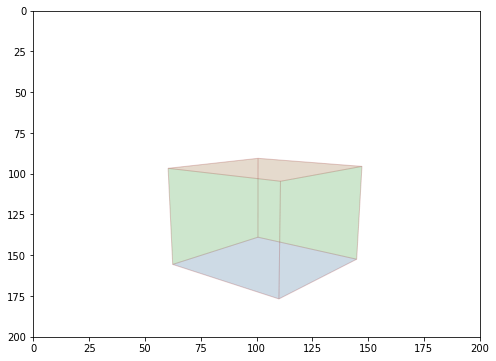

In [9]:
# プロットの設定
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# 描画範囲の設定
ax.set_xlim((0, 200))
ax.set_ylim((200, 0))

# 描画用の面の設定
verts1_2d = [pts_2d[4],pts_2d[5],pts_2d[6],pts_2d[7]]
verts2_2d = [pts_2d[0],pts_2d[1],pts_2d[2],pts_2d[3]]
verts3_2d = [[pts_2d[0],pts_2d[1],pts_2d[5],pts_2d[4]],
             [pts_2d[2],pts_2d[3],pts_2d[7],pts_2d[6]],
             [pts_2d[1],pts_2d[2],pts_2d[6],pts_2d[5]],
             [pts_2d[4],pts_2d[7],pts_2d[3],pts_2d[0]]]

# 立体の投影結果の描画
# 上面
p = pat.Polygon(verts1_2d, fc = "red", ec = "darkred",alpha= 0.1)
ax.add_patch(p)
# 下面
p = pat.Polygon(verts2_2d, fc = "blue", ec = "darkred",alpha= 0.1)
ax.add_patch(p)
# 側面
for i in range(4):
  p = pat.Polygon(verts3_2d[i], fc = "green", ec = "darkred",alpha= 0.1)
  ax.add_patch(p)

# グラフの表示
plt.show()

## 課題

Step4で表示される箱の位置・大きさを以下のように変化させるには，
Step2における `Tw`, `f`, の値をどのように変更させればよいかを回答してください．

1. 右に移動させる
2. 上に移動させる
3. 大きくする

各パラメータの意味と世界座標系・カメラ座標系の向きを考えると良いです．

また，課題とはしませんが，Step1, Step2における`cube_pos`, `Rwc`,`cx, cy`を変更させても，箱の見え方が変わります．こちらもパラメータの意味を考えながら，値を色々と変更させてみてください．
